# Modelo predictivo de la superficie de bosque deforestado en las regiones de Colombia


### Diccionario de datos

| Variable           | Tipo             | Descripción |
|--------------------|------------------|-------------|
| SCBE               | Numérico decimal | Superficie de bosque estable (ha) |
| SD                 | Numérico decimal | Superficie deforestada (ha) |
| SR                 | Numérico decimal | Superficie regenerada (ha)|
| SSIN               | Numérico decimal | Superficie sin información (ha)|
| PSSIN              | Numérico decimal | Proporción de la superficie  sin información (%) |
| TAD                | Numérico decimal | Tasa anual de deforestación (%) |
| DNSB               | Numérico decimal | Diferencia neta de la superficie cubierta por bosque periodo t1 : t2|
| CSBN               | Numérico decimal | Cambio superficie cubierta por bosque  |


## 1. Importar Librerias





In [197]:
#Tratamiento de data y gráficos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import mannwhitneyu
from google.colab import files
#Modelos

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 2. Importación de la Data

In [198]:
df = pd.read_excel("/content/drive/Othercomputers/Mi portátil (1)/Google Drive/Doctorado/1.Seminario_I/Articulo/TasaDeforestaciónCamBosqueDptos.xlsx")
df

,DEPARTAMENTO,PERIODO,SCBE,SD,SR,SSIN,PSSIN,TDA,DNSB,CSBN
0,AMAZONAS,2005-2006,1.063203e+07,4927.6,595.8,905.4,0.0,-0.050000,-4331.8,-866.4
1,AMAZONAS,2006-2007,1.063203e+07,4927.6,595.8,905.4,0.0,-0.050000,-4331.8,-866.4
2,AMAZONAS,2007-2008,1.063203e+07,4927.6,595.8,905.4,0.0,-0.050000,-4331.8,-866.4
3,AMAZONAS,2008-2009,1.063203e+07,4927.6,595.8,905.4,0.0,-0.050000,-4331.8,-866.4
4,AMAZONAS,2009-2010,1.063203e+07,4927.6,595.8,905.4,0.0,-0.050000,-4331.8,-866.4
...,...,...,...,...,...,...,...,...,...,...
556,VICHADA,2017-2018,4.114132e+06,6745.0,200.0,0.0,0.0,-0.160000,-6546.0,-6546.0
557,VICHADA,2018-2019,4.108222e+06,5587.0,0.0,2.0,0.0,-0.140000,-5587.0,-5587.0
558,VICHADA,2019-2020,4.099445e+06,5095.0,0.0,13.0,0.0,-0.124219,-5095.0,-5095.0
559,VICHADA,2020-2021,4.092627e+06,3952.0,31.0,13.0,0.0,-0.096528,-3921.0,-3921.0


## 3. Calcular departamentos con mayor indice de deforestación
### Calculo de media de TDA, SCBE, DNSB y la relación DNSB/SCBE

In [199]:
# Agrupar pr 'DEPARTAMENTO' y calcular media de TDA, SCBE, and DNSB
department_stats = df.groupby('DEPARTAMENTO').agg(
    mean_TDA=('TDA', 'mean'),
    mean_SCBE=('SCBE', 'mean'),
    mean_DNSB=('DNSB', 'mean')
).reset_index()

# Calcular relaciones
department_stats['DNSB/SCBE'] = department_stats['mean_DNSB'] / department_stats['mean_SCBE']
department_stats['DNSB/SCBE%'] = department_stats['DNSB/SCBE']*100

# Ordenar departamentos por relación DNSB/SCBE de mayor a manor
sorted_by_SCBE_ratio = department_stats.sort_values(by='DNSB/SCBE', ascending=False)
sorted_by_SCBE_ratio

,DEPARTAMENTO,mean_TDA,mean_SCBE,mean_DNSB,DNSB/SCBE,DNSB/SCBE%
0,AMAZONAS,-0.027306,1.062239e+07,-2556.117647,-0.000241,-0.024063
15,GUAINÍA,-0.019344,6.618399e+06,-1812.588235,-0.000274,-0.027387
31,VAUPÉS,-0.023476,5.162693e+06,-1764.352941,-0.000342,-0.034175
32,VICHADA,-0.076514,4.118863e+06,-3880.058824,-0.000942,-0.094202
4,"BOGOTÁ,D.C",-0.055294,8.915269e+03,-9.941176,-0.001115,-0.111507
30,VALLE DEL CAUCA,-0.085943,8.549901e+05,-1086.411765,-0.001271,-0.127067
25,RISARALDA,-0.126501,1.321844e+05,-347.235294,-0.002627,-0.262690
12,CHOCÓ,-0.218935,3.788699e+06,-10988.176471,-0.002900,-0.290025
21,NARIÑO,-0.260158,1.748915e+06,-5520.352941,-0.003156,-0.315644
10,CAUCA,-0.150335,1.411666e+06,-4460.000000,-0.003159,-0.315939


## 4. Departamentos con relación DNSB/SCBE más alta

In [200]:
# La relación DNSB/SCBE más alta la tienen los departamentos de Atlántico, Sucre, Santander y Meta
# quiere decir que los departamentos que mayor defosrestación presentan en función de cantidad de bosque que poseen
#sorted_by_SCBE_ratio['DEPARTAMENTO']

# Crear una lista para almacenar los DataFrames filtrados
dataframes_filtrados = []

# Imprimir los valores para cada categoría de 'DEPARTAMENTO'
for categoria in ['ATLÁNTICO', 'SUCRE', 'SANTANDER', 'META']:
  df_filtrado = sorted_by_SCBE_ratio[sorted_by_SCBE_ratio['DEPARTAMENTO'] == categoria]
  dataframes_filtrados.append(df_filtrado)

# Concatenar todos los DataFrames filtrados en uno solo
tabla_combinada = pd.concat(dataframes_filtrados)
tabla_combinada[['DEPARTAMENTO','DNSB/SCBE']]

,DEPARTAMENTO,DNSB/SCBE
3,ATLÁNTICO,-0.027893
28,SUCRE,-0.023736
27,SANTANDER,-0.009413
20,META,-0.008593


In [201]:
# Ver el tipo de datos actual
print(df.dtypes)

DEPARTAMENTO     object
PERIODO          object
SCBE            float64
SD              float64
SR              float64
SSIN            float64
PSSIN           float64
TDA             float64
DNSB            float64
CSBN            float64
dtype: object


In [202]:
# Convertir columnas a 'float64' e 'int'
df['SCBE'] = df['SCBE'].astype(int)
df['SD'] = df['SD'].astype(int)
df['SR'] = df['SR'].astype(int)
df['SSIN'] = df['SSIN'].astype(int)
df['PSSIN'] = df['PSSIN'].astype(float)
df['TDA'] = df['TDA'].astype(float)
df['DNSB'] = df['DNSB'].astype(int)
df['CSBN'] = df['CSBN'].astype(int)
print(df.dtypes)

DEPARTAMENTO     object
PERIODO          object
SCBE              int64
SD                int64
SR                int64
SSIN              int64
PSSIN           float64
TDA             float64
DNSB              int64
CSBN              int64
dtype: object


In [203]:
df

,DEPARTAMENTO,PERIODO,SCBE,SD,SR,SSIN,PSSIN,TDA,DNSB,CSBN
0,AMAZONAS,2005-2006,10632027,4927,595,905,0.0,-0.050000,-4331,-866
1,AMAZONAS,2006-2007,10632027,4927,595,905,0.0,-0.050000,-4331,-866
2,AMAZONAS,2007-2008,10632027,4927,595,905,0.0,-0.050000,-4331,-866
3,AMAZONAS,2008-2009,10632027,4927,595,905,0.0,-0.050000,-4331,-866
4,AMAZONAS,2009-2010,10632027,4927,595,905,0.0,-0.050000,-4331,-866
...,...,...,...,...,...,...,...,...,...,...
556,VICHADA,2017-2018,4114132,6745,200,0,0.0,-0.160000,-6546,-6546
557,VICHADA,2018-2019,4108222,5587,0,2,0.0,-0.140000,-5587,-5587
558,VICHADA,2019-2020,4099445,5095,0,13,0.0,-0.124219,-5095,-5095
559,VICHADA,2020-2021,4092627,3952,31,13,0.0,-0.096528,-3921,-3921


## 5. Calcular relación DNSB/SCBE para cada registro

In [204]:
# Calculate the ratios
df['DNSB/SCBE'] = df['DNSB'] / df['SCBE']
df

,DEPARTAMENTO,PERIODO,SCBE,SD,SR,SSIN,PSSIN,TDA,DNSB,CSBN,DNSB/SCBE
0,AMAZONAS,2005-2006,10632027,4927,595,905,0.0,-0.050000,-4331,-866,-0.000407
1,AMAZONAS,2006-2007,10632027,4927,595,905,0.0,-0.050000,-4331,-866,-0.000407
2,AMAZONAS,2007-2008,10632027,4927,595,905,0.0,-0.050000,-4331,-866,-0.000407
3,AMAZONAS,2008-2009,10632027,4927,595,905,0.0,-0.050000,-4331,-866,-0.000407
4,AMAZONAS,2009-2010,10632027,4927,595,905,0.0,-0.050000,-4331,-866,-0.000407
...,...,...,...,...,...,...,...,...,...,...,...
556,VICHADA,2017-2018,4114132,6745,200,0,0.0,-0.160000,-6546,-6546,-0.001591
557,VICHADA,2018-2019,4108222,5587,0,2,0.0,-0.140000,-5587,-5587,-0.001360
558,VICHADA,2019-2020,4099445,5095,0,13,0.0,-0.124219,-5095,-5095,-0.001243
559,VICHADA,2020-2021,4092627,3952,31,13,0.0,-0.096528,-3921,-3921,-0.000958


In [205]:
df[['AÑO_INI', 'AÑO_FIN']] = df['PERIODO'].str.split('-', expand=True)
df

,DEPARTAMENTO,PERIODO,SCBE,SD,SR,SSIN,PSSIN,TDA,DNSB,CSBN,DNSB/SCBE,AÑO_INI,AÑO_FIN
0,AMAZONAS,2005-2006,10632027,4927,595,905,0.0,-0.050000,-4331,-866,-0.000407,2005,2006
1,AMAZONAS,2006-2007,10632027,4927,595,905,0.0,-0.050000,-4331,-866,-0.000407,2006,2007
2,AMAZONAS,2007-2008,10632027,4927,595,905,0.0,-0.050000,-4331,-866,-0.000407,2007,2008
3,AMAZONAS,2008-2009,10632027,4927,595,905,0.0,-0.050000,-4331,-866,-0.000407,2008,2009
4,AMAZONAS,2009-2010,10632027,4927,595,905,0.0,-0.050000,-4331,-866,-0.000407,2009,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,VICHADA,2017-2018,4114132,6745,200,0,0.0,-0.160000,-6546,-6546,-0.001591,2017,2018
557,VICHADA,2018-2019,4108222,5587,0,2,0.0,-0.140000,-5587,-5587,-0.001360,2018,2019
558,VICHADA,2019-2020,4099445,5095,0,13,0.0,-0.124219,-5095,-5095,-0.001243,2019,2020
559,VICHADA,2020-2021,4092627,3952,31,13,0.0,-0.096528,-3921,-3921,-0.000958,2020,2021


In [206]:
# Cantidad de filas y columnas del DataFrame
df.shape

(561, 13)

In [207]:
# Nombres de las columnas
df.columns

Index(['DEPARTAMENTO', 'PERIODO', 'SCBE', 'SD', 'SR', 'SSIN', 'PSSIN', 'TDA',
       'DNSB', 'CSBN', 'DNSB/SCBE', 'AÑO_INI', 'AÑO_FIN'],
      dtype='object')

In [208]:
#Columnas, Cantidad de filas sin nulo y tipos de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DEPARTAMENTO  561 non-null    object 
 1   PERIODO       561 non-null    object 
 2   SCBE          561 non-null    int64  
 3   SD            561 non-null    int64  
 4   SR            561 non-null    int64  
 5   SSIN          561 non-null    int64  
 6   PSSIN         561 non-null    float64
 7   TDA           561 non-null    float64
 8   DNSB          561 non-null    int64  
 9   CSBN          561 non-null    int64  
 10  DNSB/SCBE     561 non-null    float64
 11  AÑO_INI       561 non-null    object 
 12  AÑO_FIN       561 non-null    object 
dtypes: float64(3), int64(6), object(4)
memory usage: 57.1+ KB


## 6. Gráficas TDA por Departamento (Atlántico)

In [226]:
df['AÑO_FIN'] = pd.to_numeric(df['AÑO_FIN'])

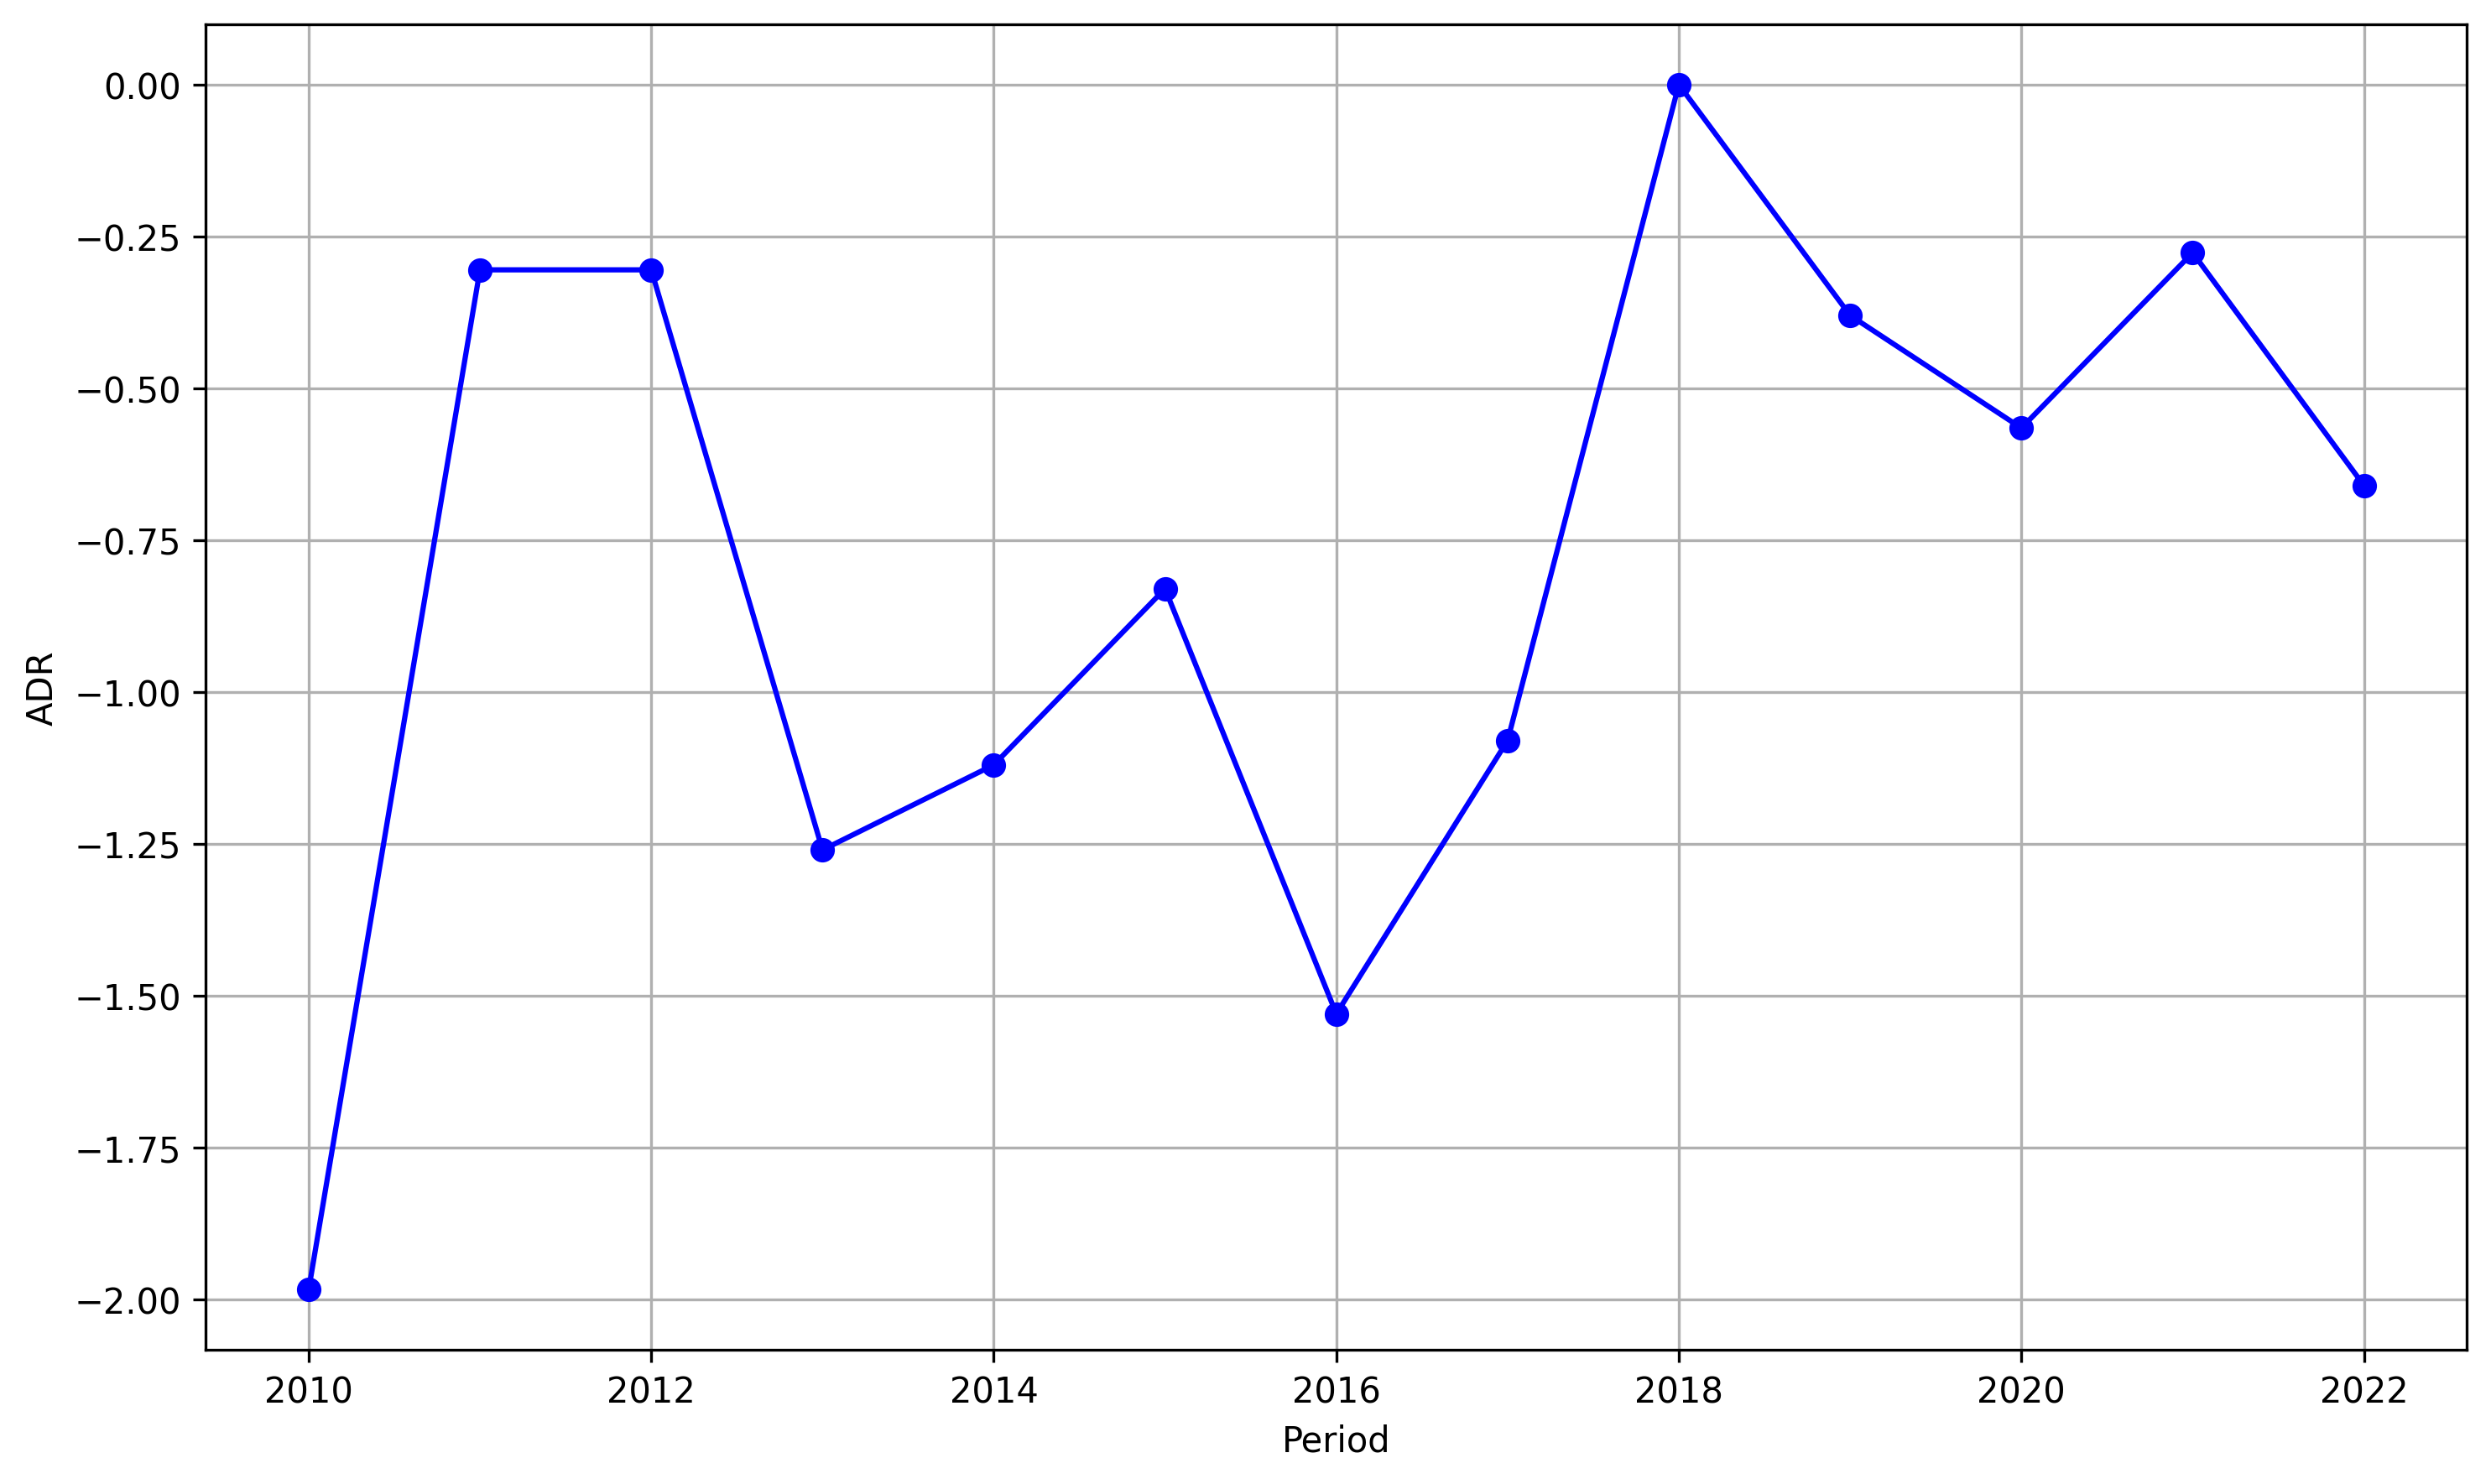

In [235]:
#TDA para el Departmento de Atlántico en Relación con el Periodo
#ADR for the Department of Atlántico in Relation to the Period

# Filtrar el DataFrame para el departamento de Atlántico y años mayores a 2009
df_atlantico = df[(df['DEPARTAMENTO'] == 'ATLÁNTICO') & (df['AÑO_FIN'] > 2009)]

# Graficar TDA en función del PERIODO para el departamento del Atlántico
plt.figure(figsize=(10, 6),dpi=300)
plt.plot(df_atlantico['AÑO_FIN'], df_atlantico['TDA'], marker='o', linestyle='-', color='b')
plt.xlabel('Period')
plt.ylabel('ADR')
plt.grid(True)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

## 6. Gráficas TDA por Departamento (Sucre)

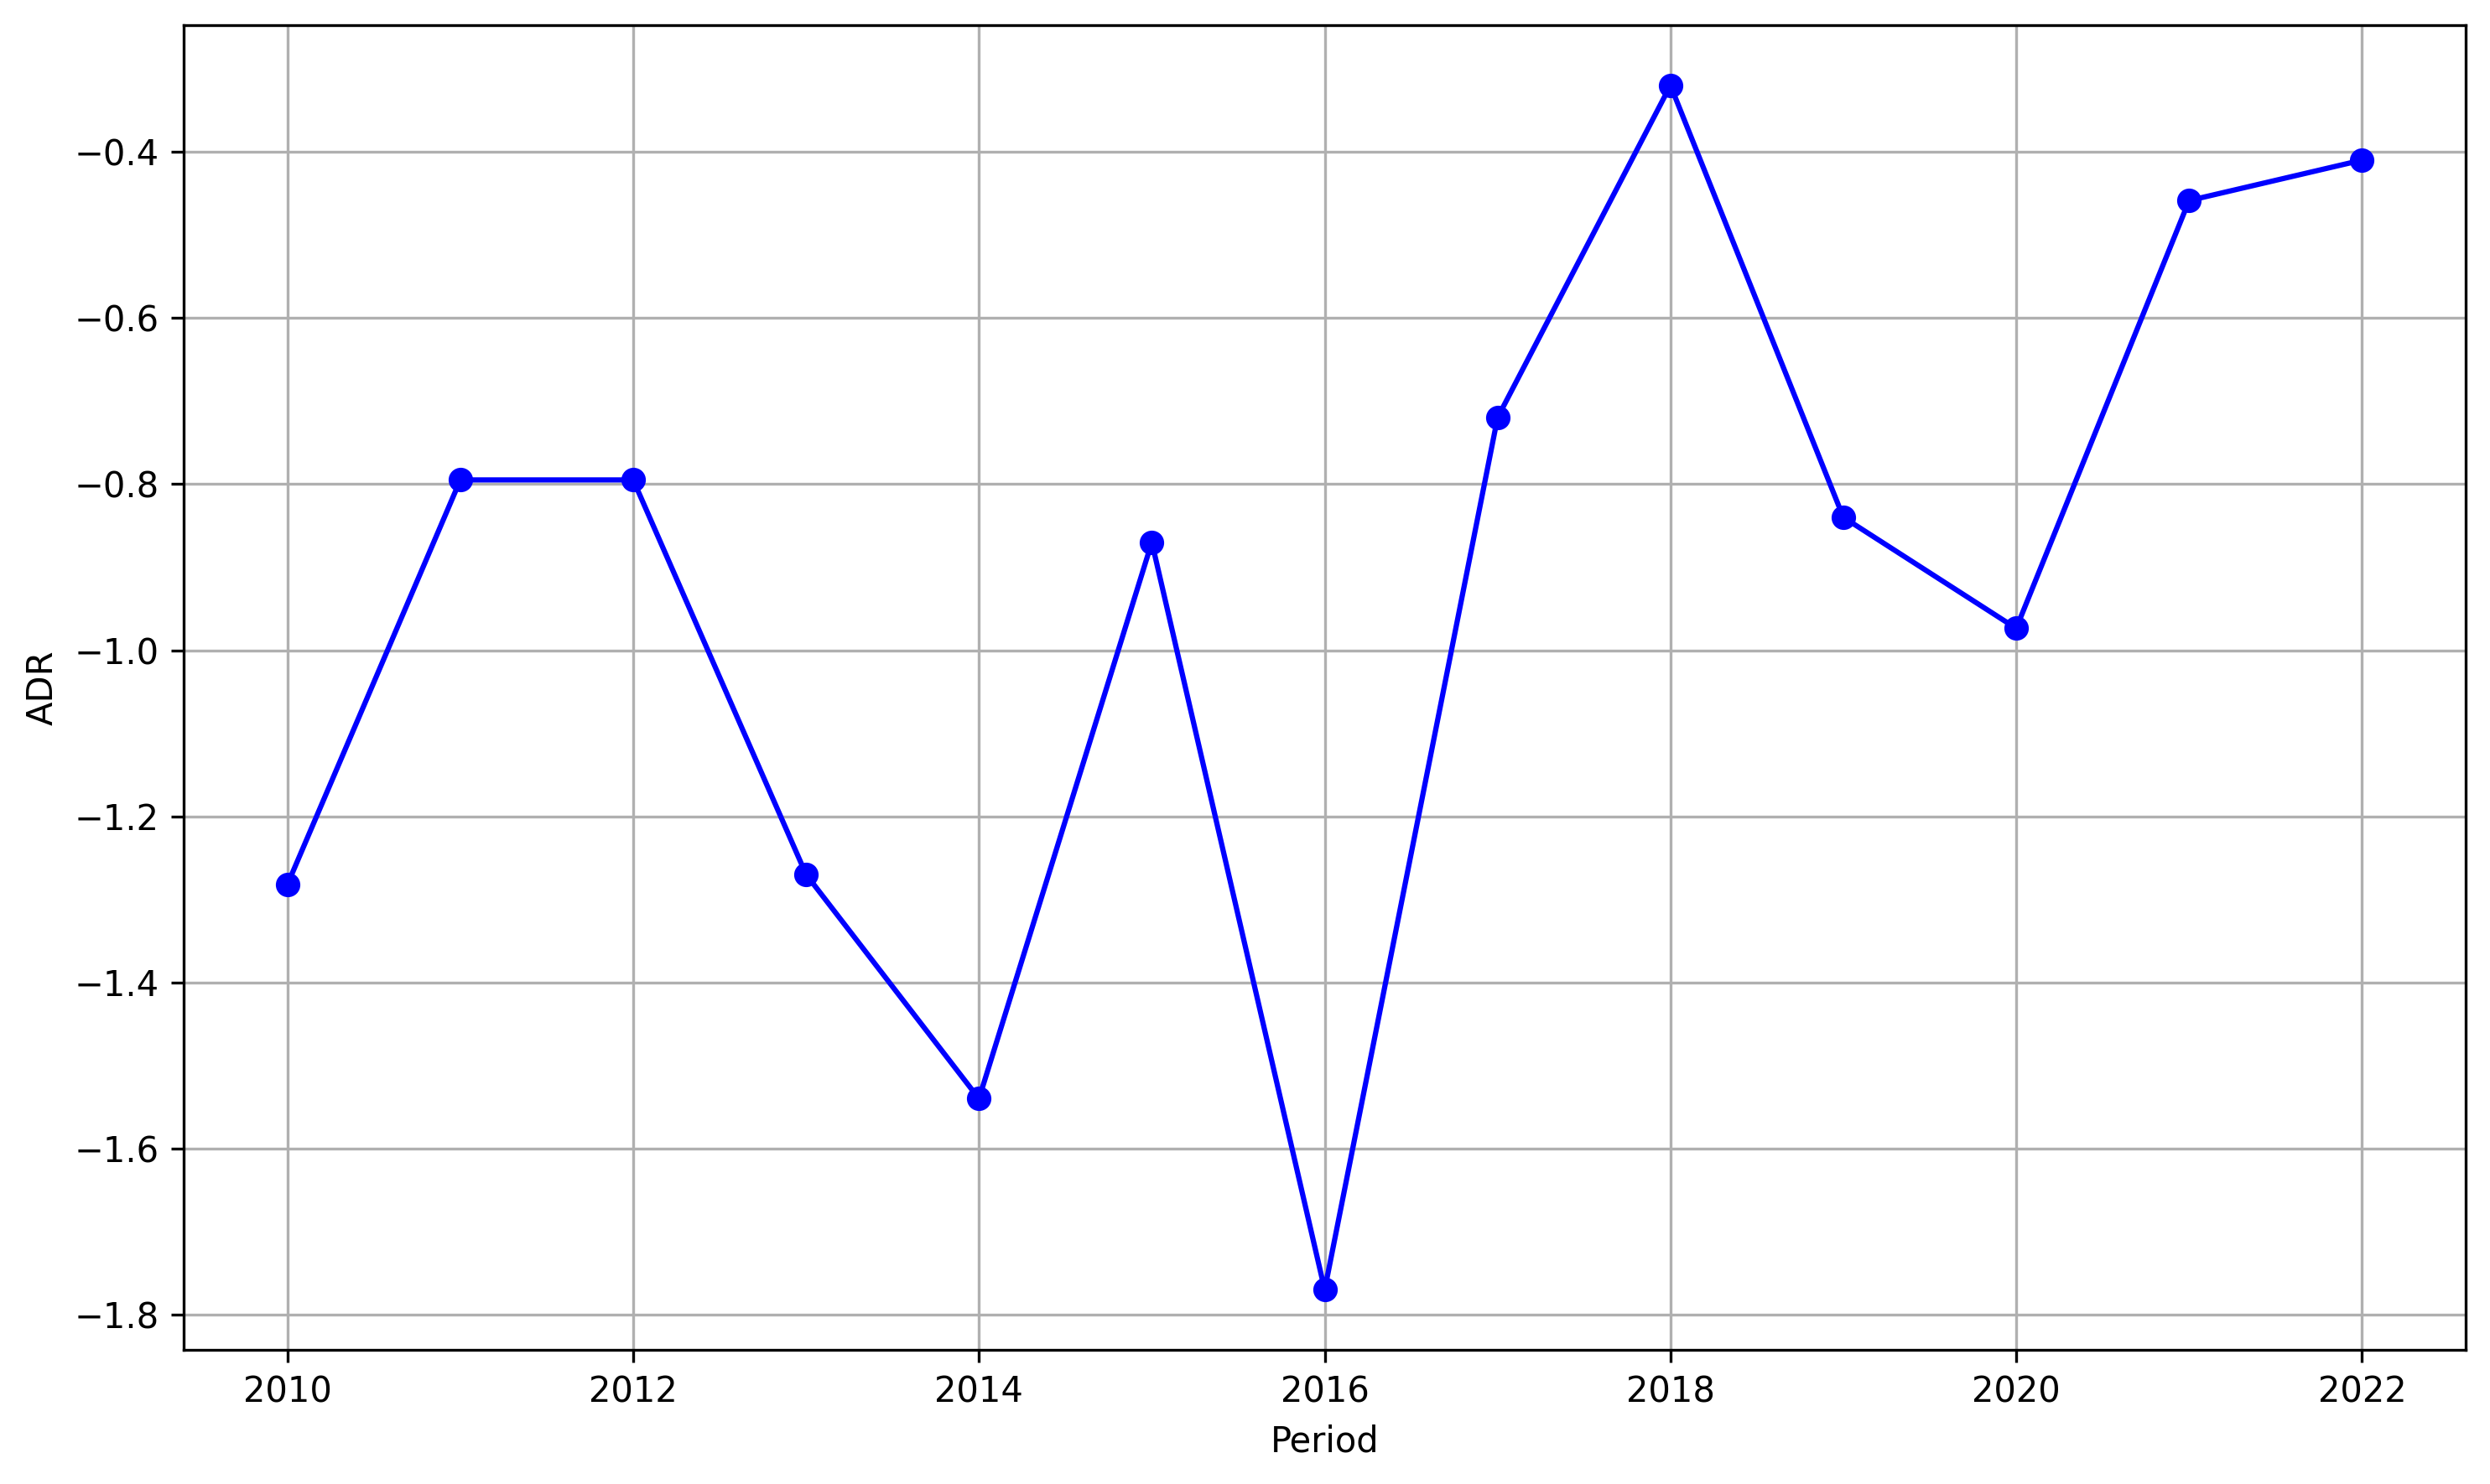

In [236]:
#TDA para el Departmento de Sucre en Relación con el Periodo
#ADR for the Department of Sucre in Relation to the Period

# Filtrar el DataFrame para el departamento de Atlántico y años mayores a 2009
df_atlantico = df[(df['DEPARTAMENTO'] == 'SUCRE') & (df['AÑO_FIN'] > 2009)]

# Graficar TDA en función del PERIODO para el departamento del Atlántico
plt.figure(figsize=(10, 6),dpi=300)
plt.plot(df_atlantico['AÑO_FIN'], df_atlantico['TDA'], marker='o', linestyle='-', color='b')
plt.xlabel('Period')
plt.ylabel('ADR')
plt.grid(True)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

## 6. Gráficas TDA por Departamento (Santander)

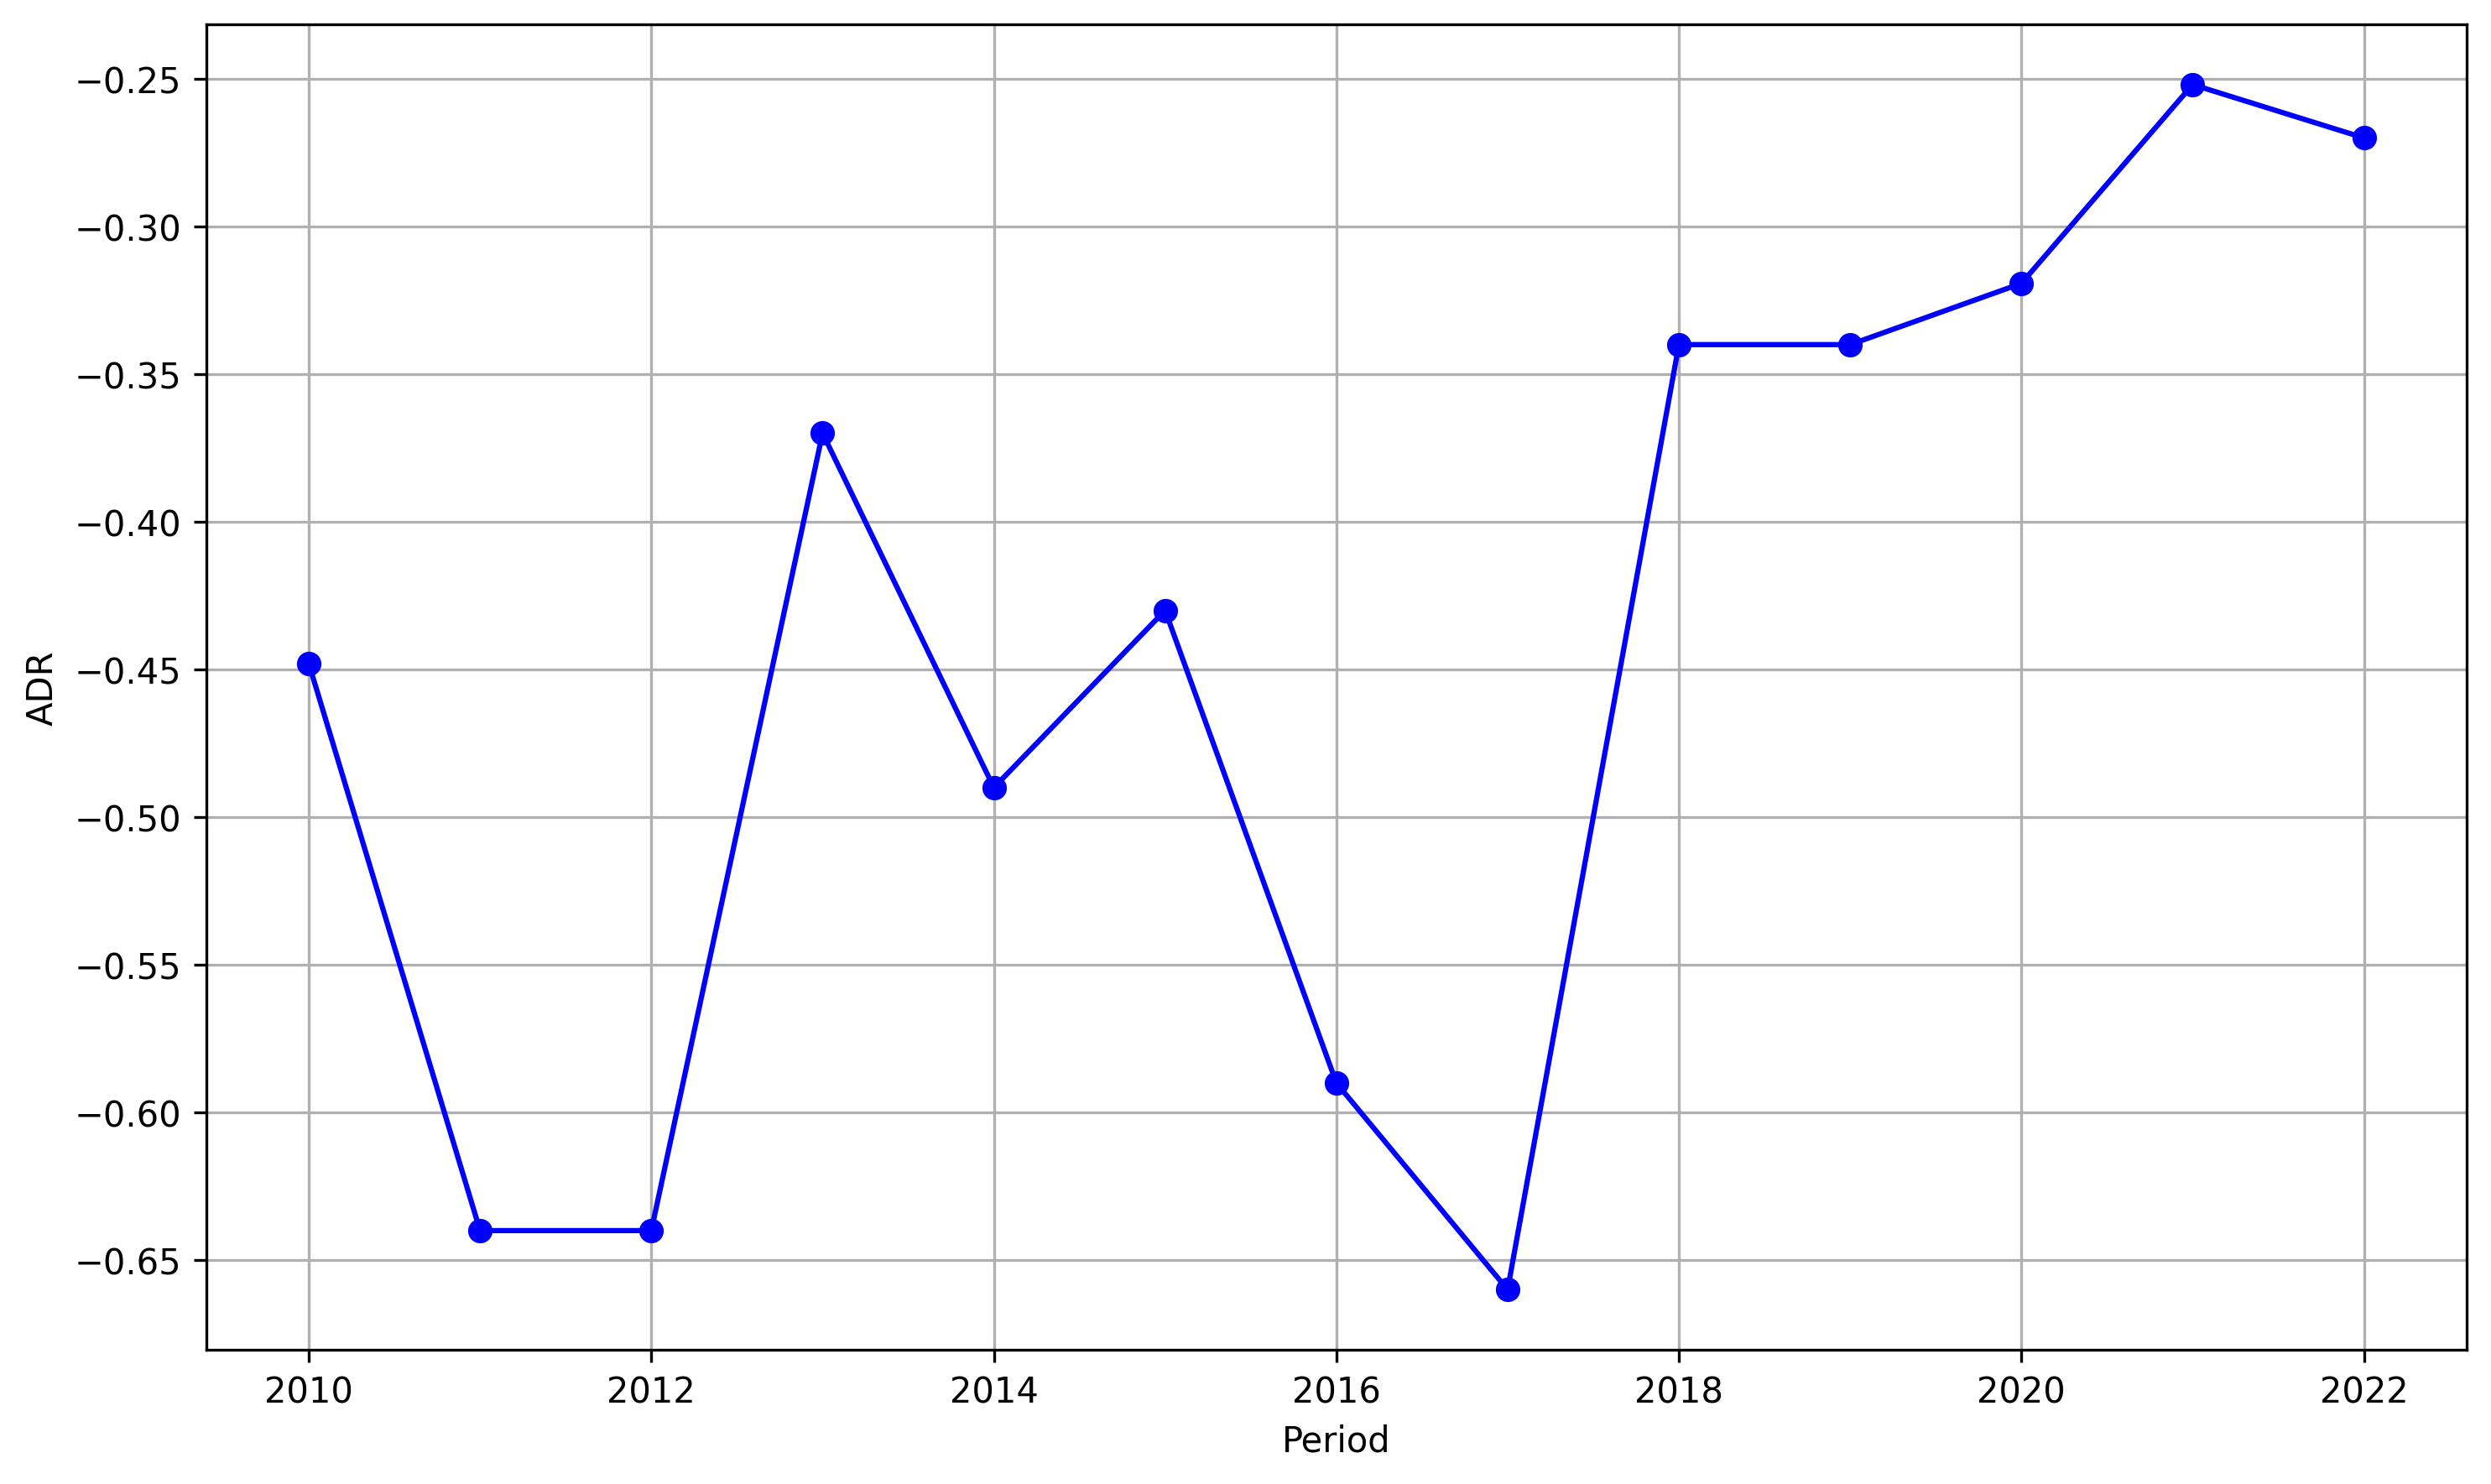

In [237]:
#TDA para el Departmento de Santander en Relación con el Periodo
#ADR for the Department of Santander in Relation to the Period

# Filtrar el DataFrame para el departamento de Atlántico y años mayores a 2009
df_atlantico = df[(df['DEPARTAMENTO'] == 'SANTANDER') & (df['AÑO_FIN'] > 2009)]

# Graficar TDA en función del PERIODO para el departamento del Atlántico
plt.figure(figsize=(10, 6),dpi=300)
plt.plot(df_atlantico['AÑO_FIN'], df_atlantico['TDA'], marker='o', linestyle='-', color='b')
plt.xlabel('Period')
plt.ylabel('ADR')
plt.grid(True)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

## 6. Gráficas TDA por Departamento (Meta)

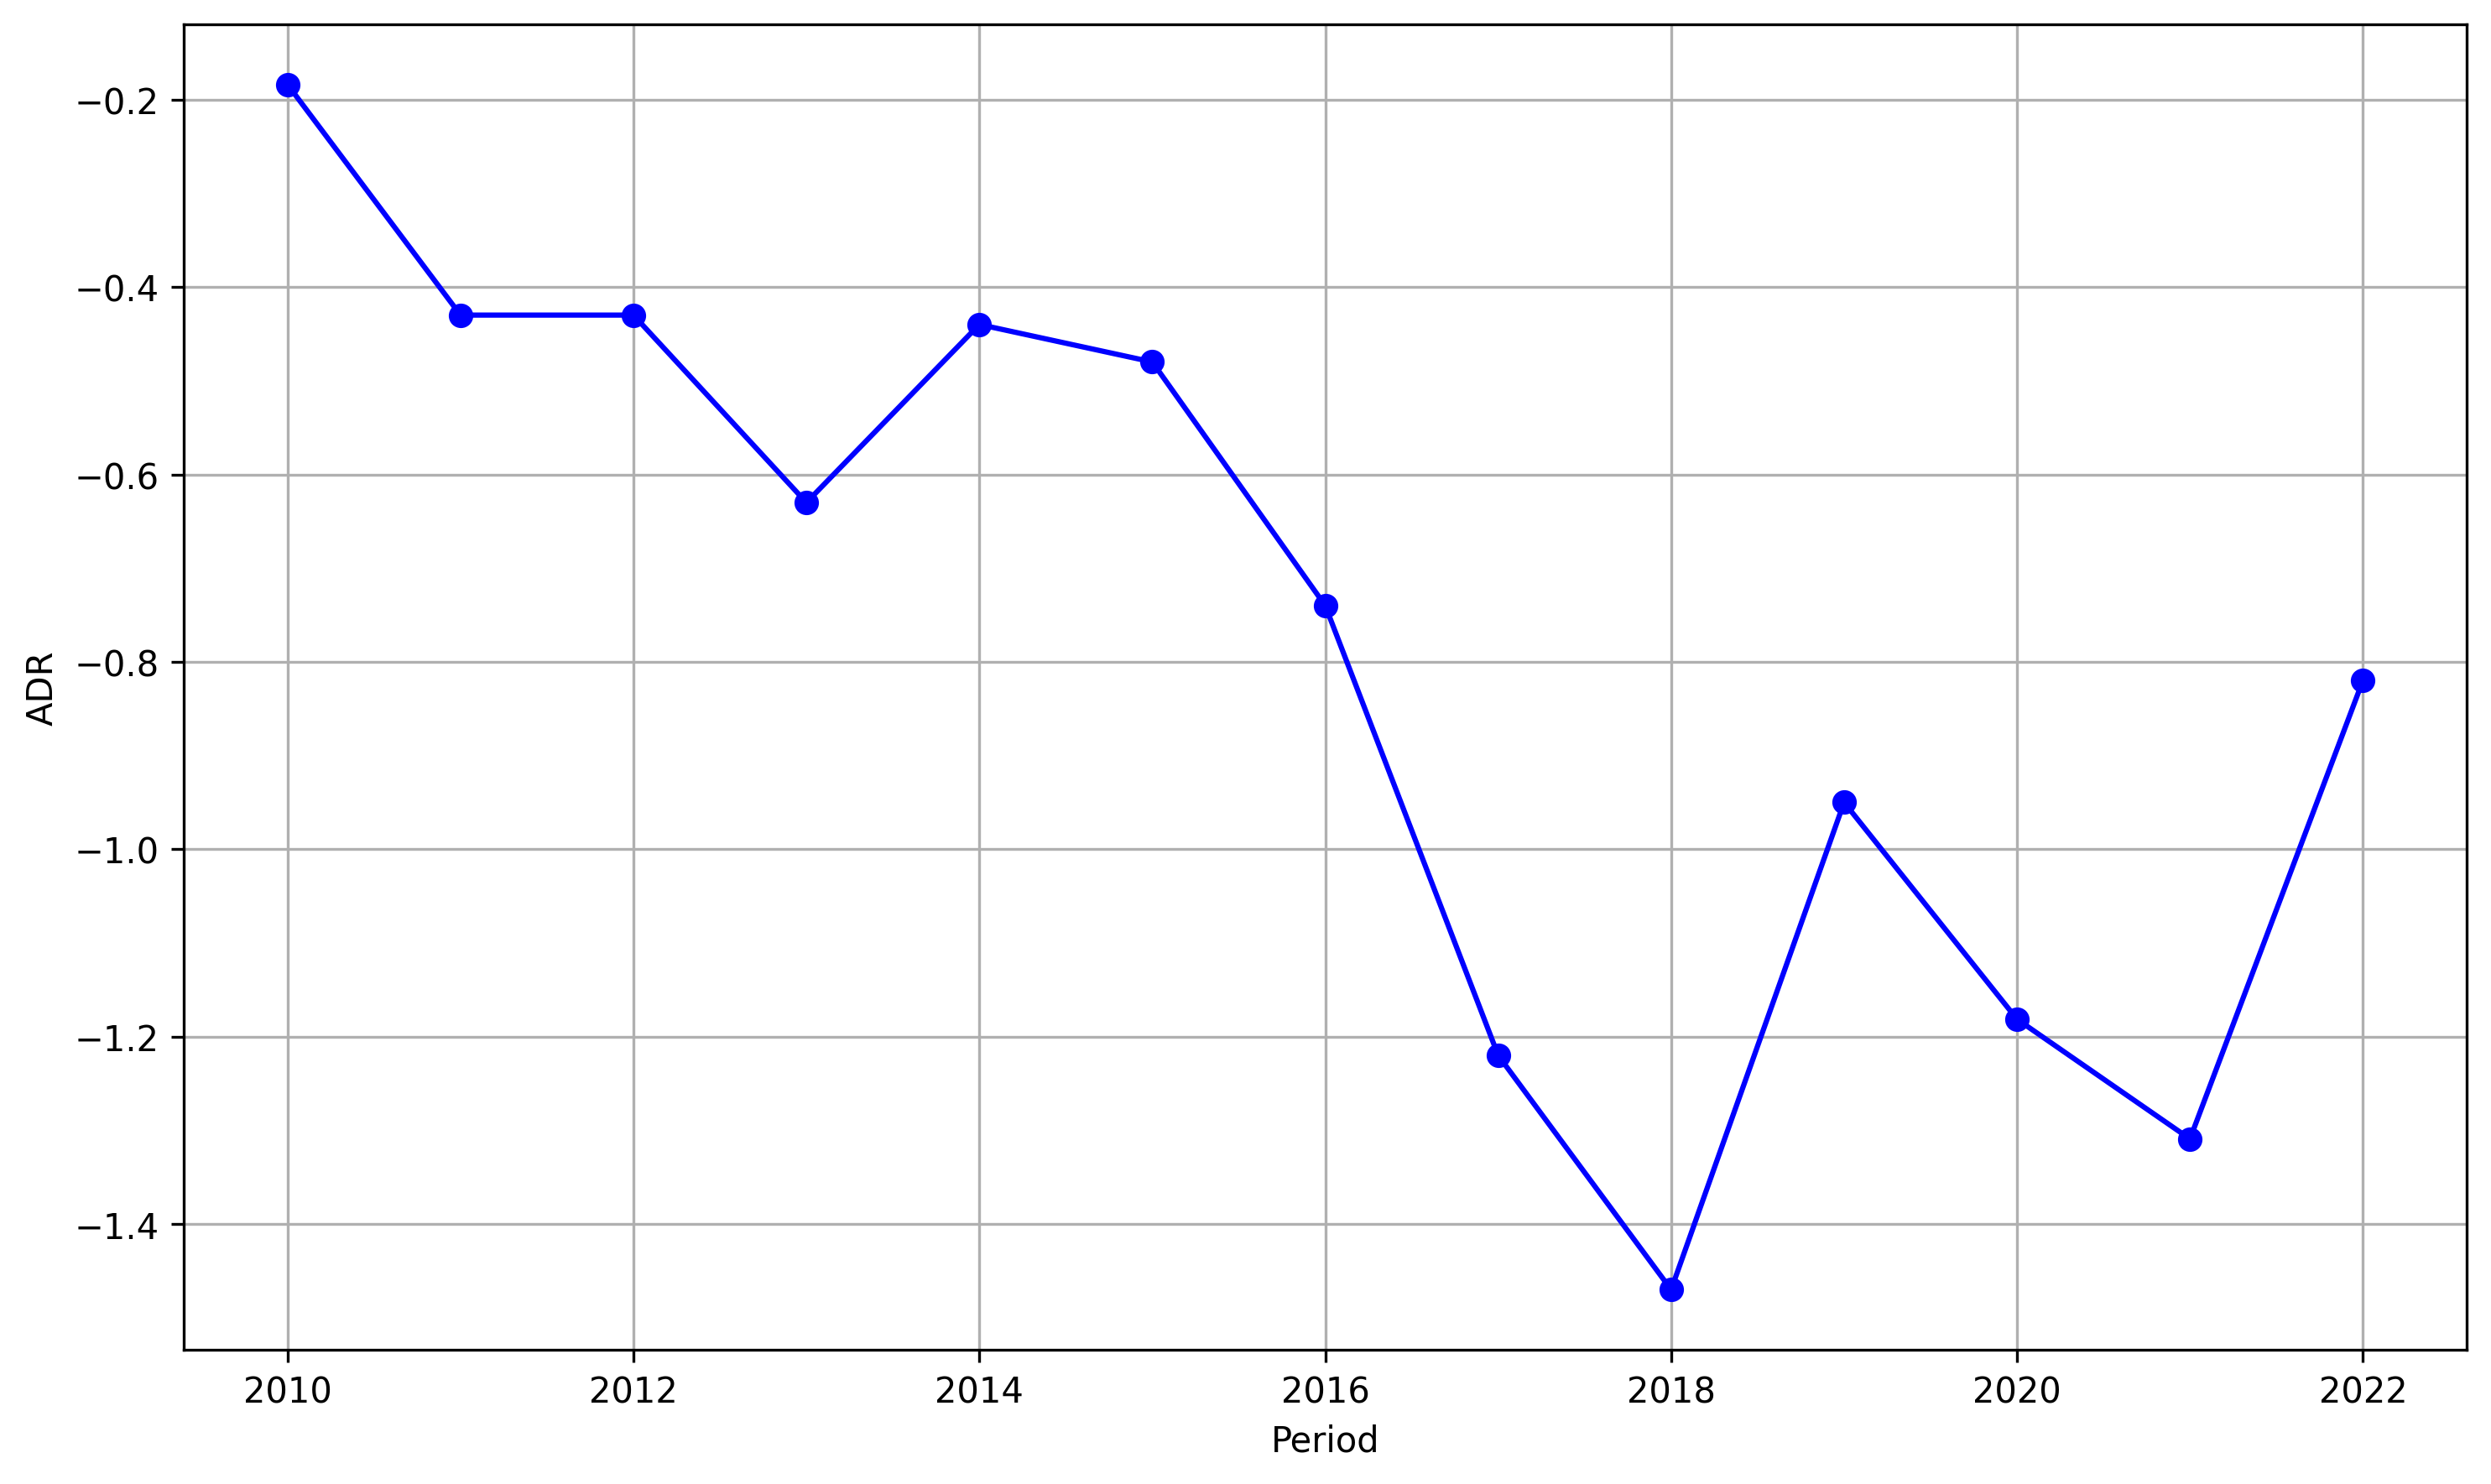

In [238]:
#TDA para el Departmento de Meta en Relación con el Periodo
#ADR for the Department of Meta in Relation to the Period

# Filtrar el DataFrame para el departamento de Atlántico y años mayores a 2009
df_atlantico = df[(df['DEPARTAMENTO'] == 'META') & (df['AÑO_FIN'] > 2009)]

# Graficar TDA en función del PERIODO para el departamento del Atlántico
plt.figure(figsize=(10, 6),dpi=300)
plt.plot(df_atlantico['AÑO_FIN'], df_atlantico['TDA'], marker='o', linestyle='-', color='b')
plt.xlabel('Period')
plt.ylabel('ADR')
plt.grid(True)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

## 7. Descripción estadistica de la data de los departamentos con mayor DNSB/SCBE

In [209]:
# Imprimir los valores para la categoría de 'DEPARTAMENTO'con mayor realación DNSB/SCBE
for categoria in ['ATLÁNTICO', 'SUCRE', 'SANTANDER', 'META']:
  df_filtrado = df[df['DEPARTAMENTO']  == categoria]
  print(f"Departamento: {categoria}","\n")
  print(df_filtrado.describe(),"\n")

Departamento: ATLÁNTICO 

              SCBE          SD          SR        SSIN      PSSIN        TDA  \
count    17.000000   17.000000   17.000000   17.000000  17.000000  17.000000   
mean   4506.588235  176.941176   51.470588  159.294118   0.041176  -1.072483   
std     374.605135  226.943955   82.191938  154.522152   0.047550   0.721462   
min    4033.000000    0.000000    0.000000    0.000000   0.000000  -1.984000   
25%    4033.000000   27.000000    0.000000    0.000000   0.000000  -1.984000   
50%    4662.000000   50.000000    0.000000  106.000000   0.000000  -1.080000   
75%    4798.000000  517.000000  175.000000  345.000000   0.100000  -0.380000   
max    5018.000000  517.000000  175.000000  345.000000   0.100000   0.000000   

             DNSB       CSBN  DNSB/SCBE  
count   17.000000  17.000000  17.000000  
mean  -125.470588 -43.117647  -0.030202  
std    145.138347  25.019698   0.036512  
min   -342.000000 -72.000000  -0.084800  
25%   -342.000000 -68.000000  -0.084800  
5

## 8. Graficar distribución de la data de los departamentos con mayor DNSB/SCBE

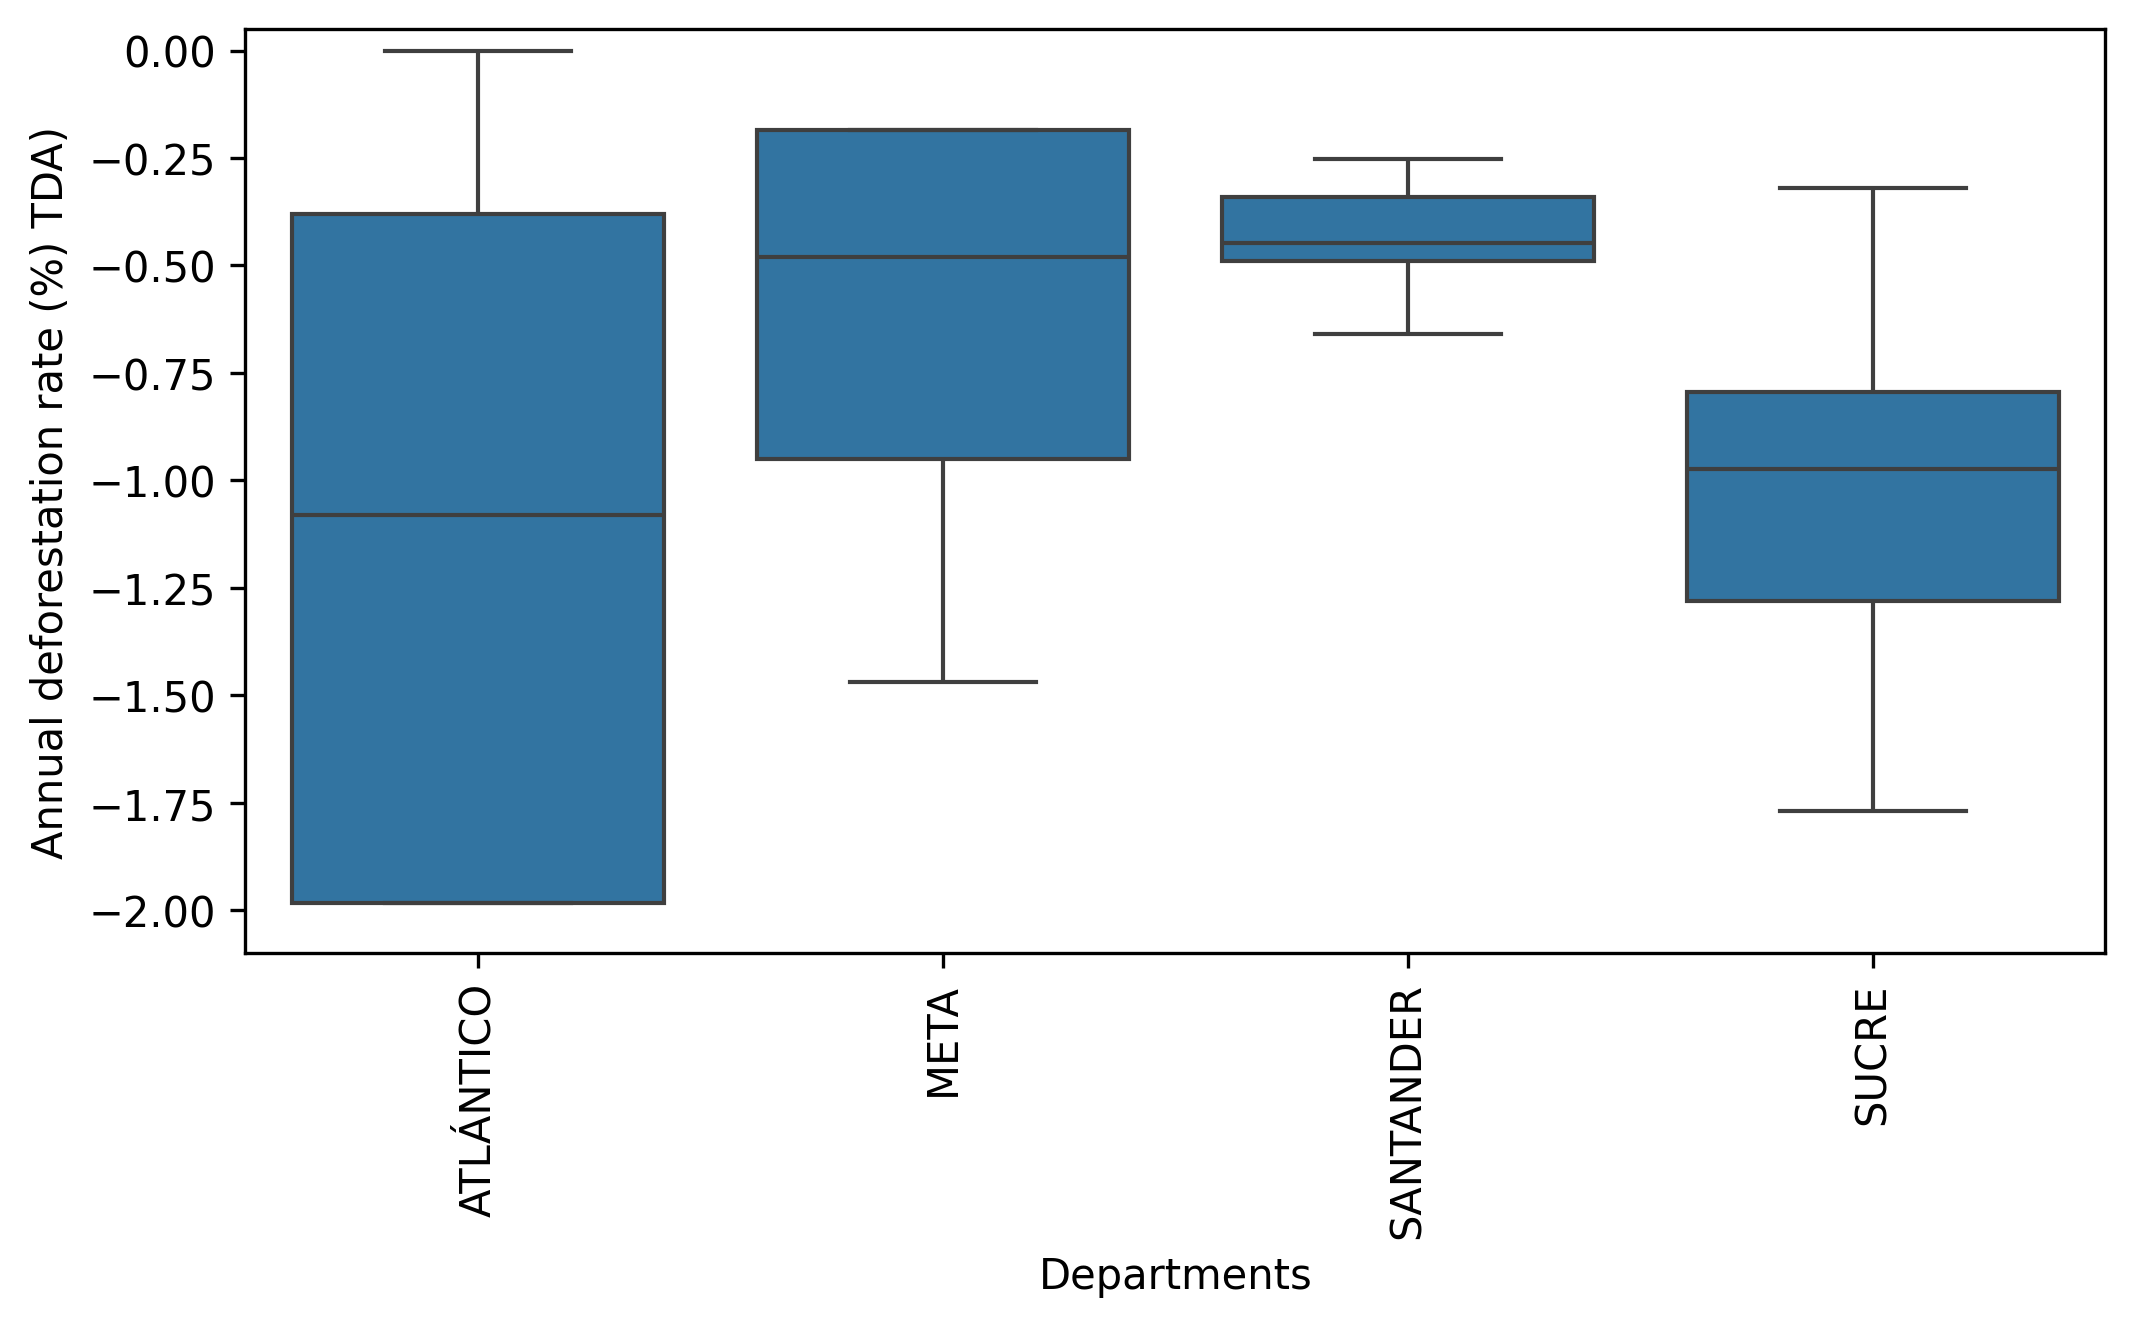

<Figure size 640x480 with 0 Axes>

In [210]:
# Especificar los cuatro departamentos con DNSB/SCBE más alta
dep_sel = ['ATLÁNTICO', 'SUCRE', 'SANTANDER', 'META']

# Filtrar el DataFrame original para incluir solo las categorías seleccionadas
df_filtrado = df[df['DEPARTAMENTO'].isin(dep_sel)]

# Seleccionar dos categorías (columnas)
df_selected = df_filtrado[['DEPARTAMENTO', 'TDA']]

plt.figure(figsize=(8, 4),dpi=300)
plt.ylim(-2.1, 0.05) # Ajustamos los límites del eje y
sns.boxplot(x='DEPARTAMENTO', y='TDA', data=df_selected)
plt.xticks(rotation=90)
#plt.title('Annual deforestation rate distribution (%) TDA')
plt.xlabel('Departments')
plt.ylabel('Annual deforestation rate (%) TDA)')
plt.show()

# Guardar la figura como EPS
plt.savefig('fig1.eps', format='eps')

# Descargar el archivo
#files.download('fig1.jpeg')

## 9. Correlación de Spearman de los departamentos con mayor DNSB/SCBE

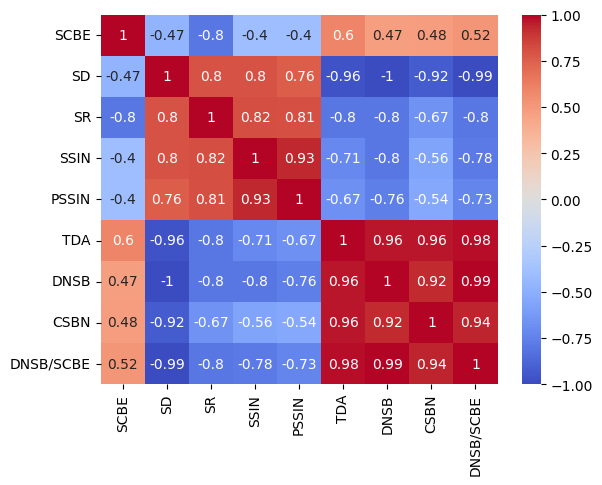

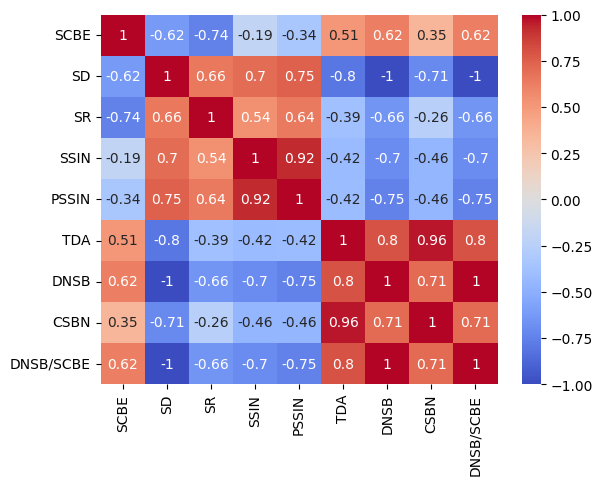

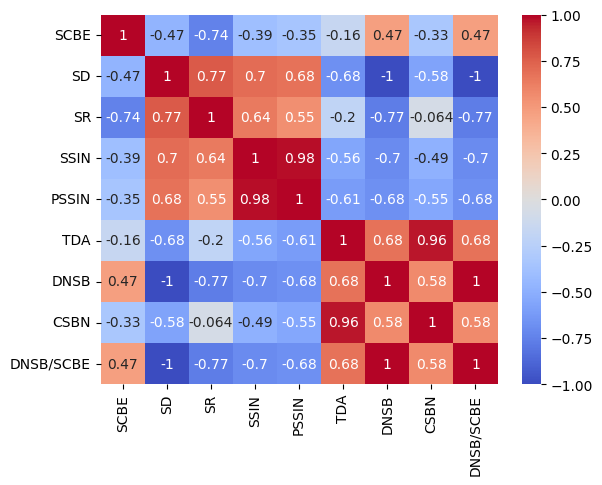

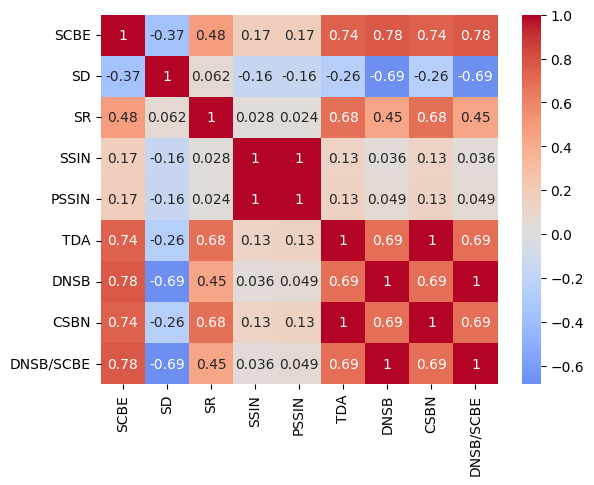

In [211]:
# Verifico la correlación entre datos para los cuatro departamentos con DNSB/SCBE más alta
caracteristicas = ['SCBE', 'SD', 'SR', 'SSIN', 'PSSIN', 'TDA','DNSB', 'CSBN', 'DNSB/SCBE']

# Imprimir los valores para cada categoría de 'DEPARTAMENTO'
for categoria in ['ATLÁNTICO', 'SUCRE', 'SANTANDER', 'META']:
  df_filtrado = df[df['DEPARTAMENTO']  == categoria]
  correlacion = df_filtrado[caracteristicas].corr(method='spearman')
  # Visualización de la matriz de correlación
  sns.heatmap(correlacion, annot=True, cmap='coolwarm', center=0)
  #plt.title(f"Departamento: {categoria}")
  plt.xticks(rotation=90)
  plt.show()
  correlacion
  #print(f"Departamento: {categoria}","\n")

In [212]:
# Departamento
df_departamento=df[df['DEPARTAMENTO']=='META']
resultado = mannwhitneyu(df_departamento['TDA'], df_departamento['DNSB'], method = 'exact')
print(resultado)

MannwhitneyuResult(statistic=289.0, pvalue=8.570426247835421e-10)


## 10. Distribución de los datos de los departamentos con mayor DNSB/SCBE

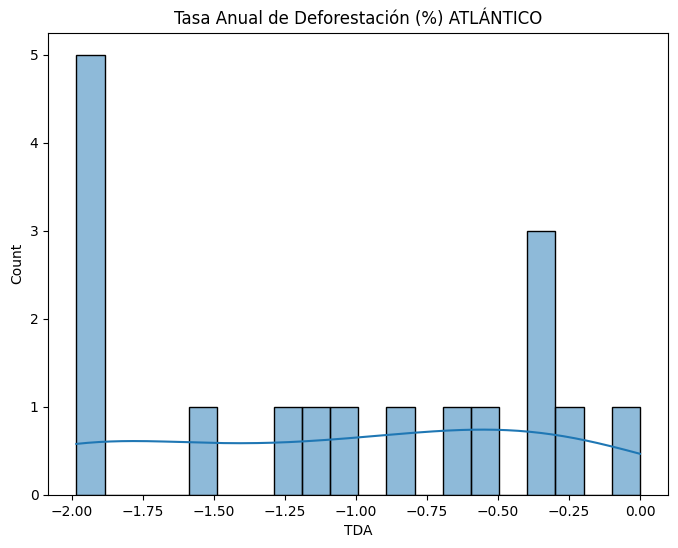

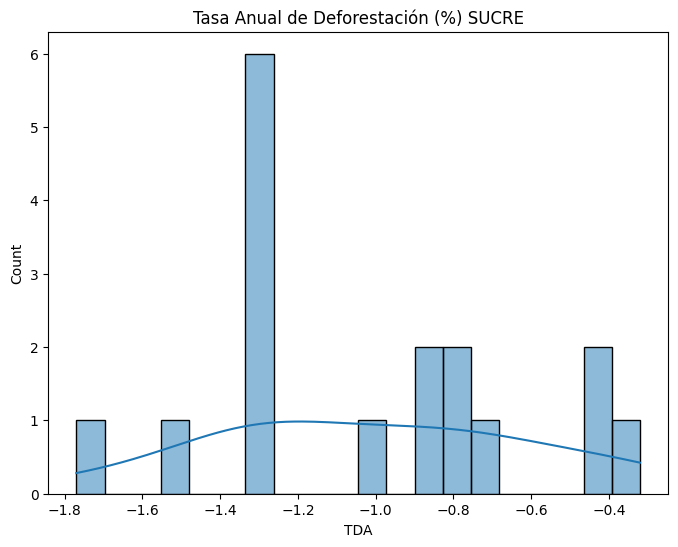

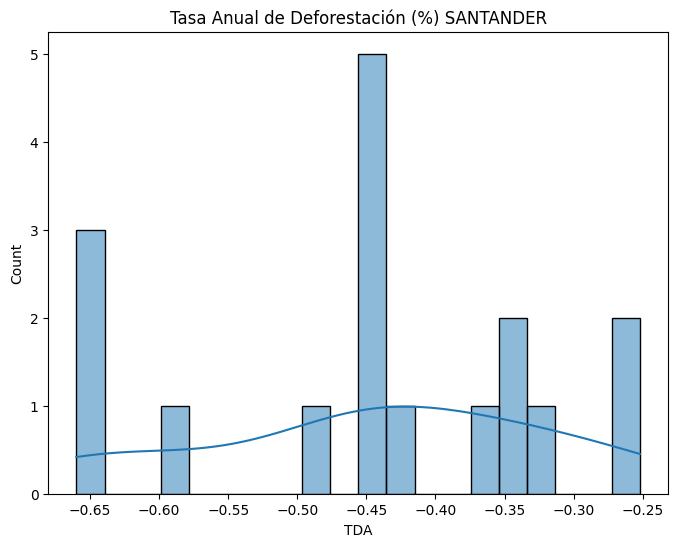

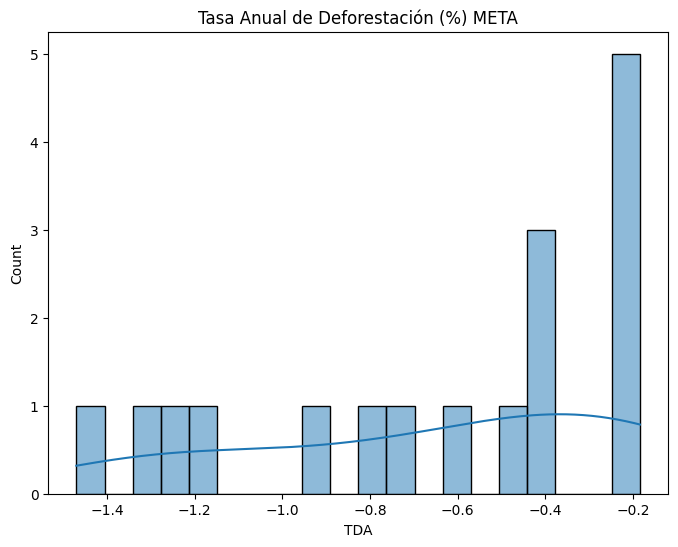

In [213]:
# Distribución de la Tasa anual de deforestación
for categoria in ['ATLÁNTICO', 'SUCRE', 'SANTANDER', 'META']:
  df_filtrado = df[df['DEPARTAMENTO']  == categoria]
  plt.figure(figsize=(8, 6))
  sns.histplot(df_filtrado['TDA'], kde=True, bins=20)
  plt.title(f"Tasa Anual de Deforestación (%) {categoria}")
  plt.show()

## 11.Gráficos de dispersión entre la Tasa anual de deforestación y otras variables

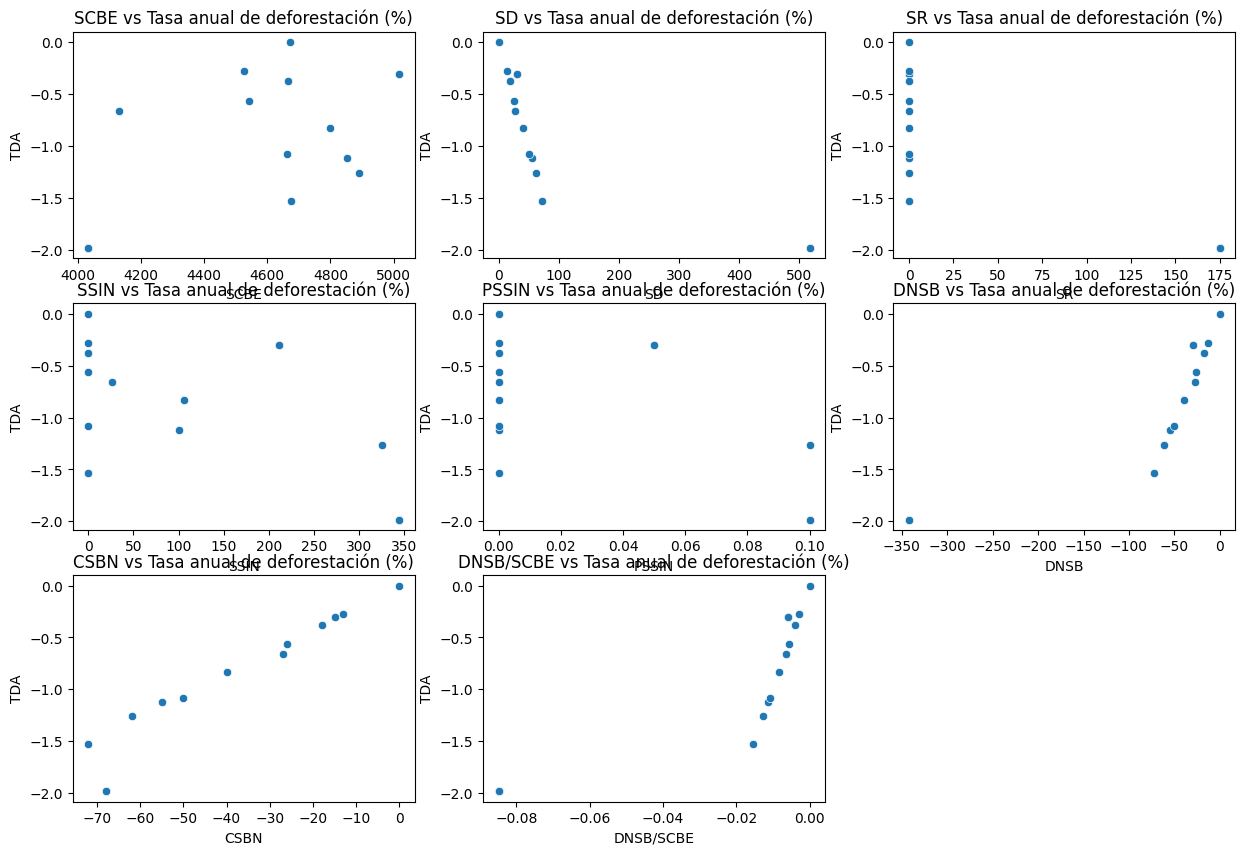

In [214]:
# Gráficos de dispersión entre la Tasa anual de deforestación y otras variables
catacteristicas = ['SCBE', 'SD', 'SR', 'SSIN', 'PSSIN', 'DNSB', 'CSBN', 'DNSB/SCBE']
df_departamento=df[df['DEPARTAMENTO']=='ATLÁNTICO']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(catacteristicas, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=df_departamento[feature], y=df_departamento['TDA'])
    plt.title(f'{feature} vs Tasa anual de deforestación (%)')

## 12. Caracteristicas más importantes (Departamento Atlántico)
Para confirmar y cuantificar la importancia de las variables predictoras, entrenaremos un modelo de Random Forest y evaluaremos la importancia de las características.
Entrenamiento del Modelo Predictivo


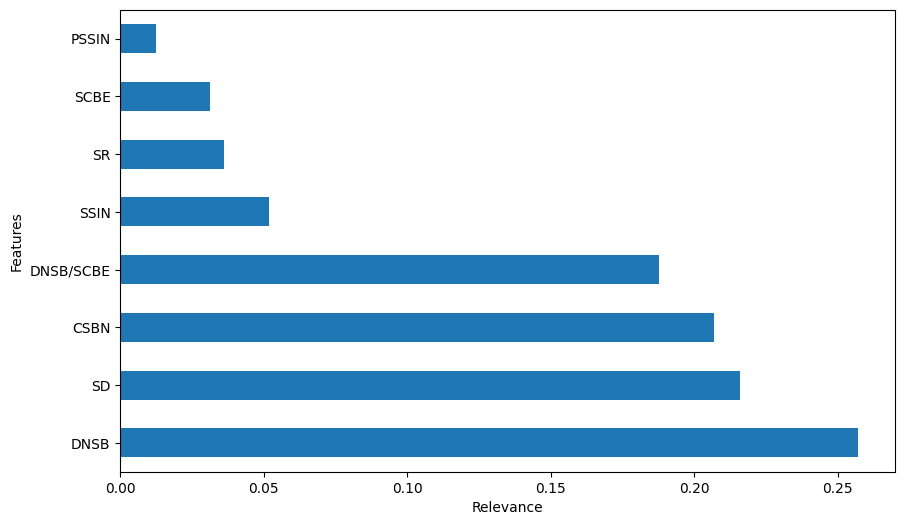

(0.06920893059385107,
 DNSB         0.257211
 SD           0.216085
 CSBN         0.206879
 DNSB/SCBE    0.187891
 SSIN         0.051966
 SR           0.036149
 SCBE         0.031395
 PSSIN        0.012422
 dtype: float64)

In [215]:
# Definimos las variables predictoras y la variable objetivo

df_departamento=df[df['DEPARTAMENTO']=='ATLÁNTICO']
X = df_departamento[['SCBE', 'SD', 'SR', 'SSIN', 'PSSIN','DNSB', 'CSBN', 'DNSB/SCBE']]
y = df_departamento['TDA']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo de Random Forest
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Realizamos predicciones y evaluamos el modelo
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Importancia de las características
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Visualizamos la importancia de las características
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='barh')
#plt.title('Importancia de las Características')
plt.xlabel('Relevance')
plt.ylabel('Features')
plt.show()
rmse, feature_importances

## 12. Caracteristicas más importantes (Departamento Sucre)

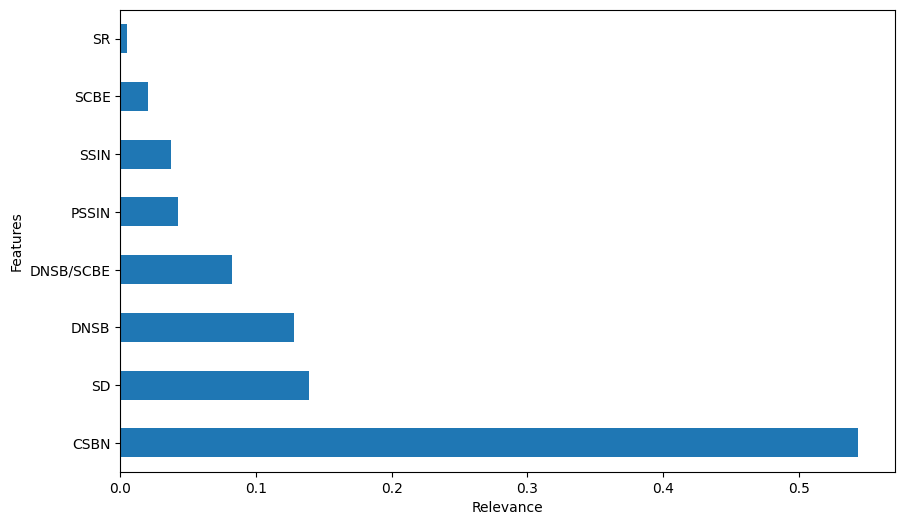

(0.09044060215288008,
 CSBN         0.544002
 SD           0.139442
 DNSB         0.128322
 DNSB/SCBE    0.082362
 PSSIN        0.042579
 SSIN         0.037606
 SCBE         0.020409
 SR           0.005278
 dtype: float64)

In [216]:
# Definimos las variables predictoras y la variable objetivo

df_departamento=df[df['DEPARTAMENTO']=='SUCRE']
X = df_departamento[['SCBE', 'SD', 'SR', 'SSIN', 'PSSIN','DNSB', 'CSBN', 'DNSB/SCBE']]
y = df_departamento['TDA']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo de Random Forest
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Realizamos predicciones y evaluamos el modelo
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Importancia de las características
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Visualizamos la importancia de las características
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='barh')
#plt.title('Importancia de las Características')
plt.xlabel('Relevance')
plt.ylabel('Features')
plt.show()
rmse, feature_importances

## 12. Caracteristicas más importantes (Departamento Meta)

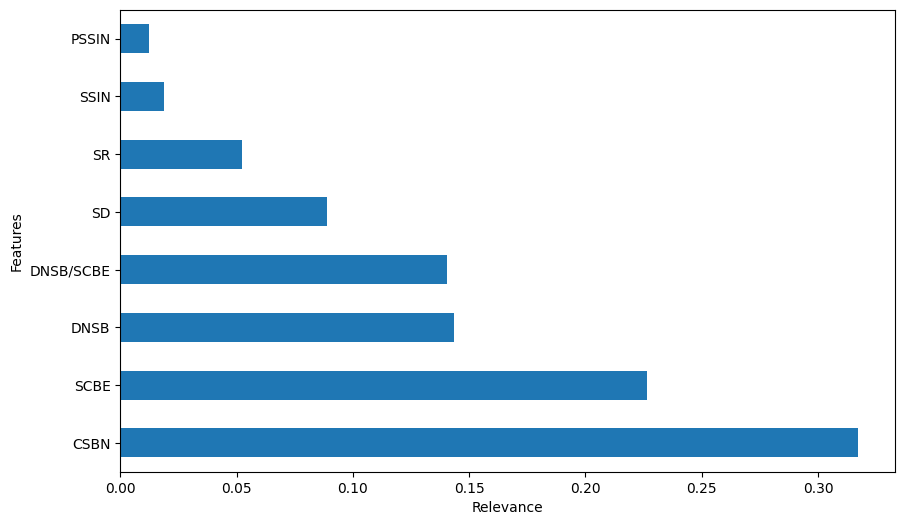

(0.07720087308166729,
 CSBN         0.317364
 SCBE         0.226493
 DNSB         0.143505
 DNSB/SCBE    0.140300
 SD           0.089028
 SR           0.052223
 SSIN         0.018863
 PSSIN        0.012224
 dtype: float64)

In [217]:
# Definimos las variables predictoras y la variable objetivo

df_departamento=df[df['DEPARTAMENTO']=='META']
X = df_departamento[['SCBE', 'SD', 'SR', 'SSIN', 'PSSIN','DNSB', 'CSBN', 'DNSB/SCBE']]
y = df_departamento['TDA']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo de Random Forest
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Realizamos predicciones y evaluamos el modelo
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Importancia de las características
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Visualizamos la importancia de las características
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='barh')
#plt.title('Importancia de las Características')
plt.xlabel('Relevance')
plt.ylabel('Features')
plt.show()
rmse, feature_importances

## 12. Caracteristicas más importantes (Departamento Santander)

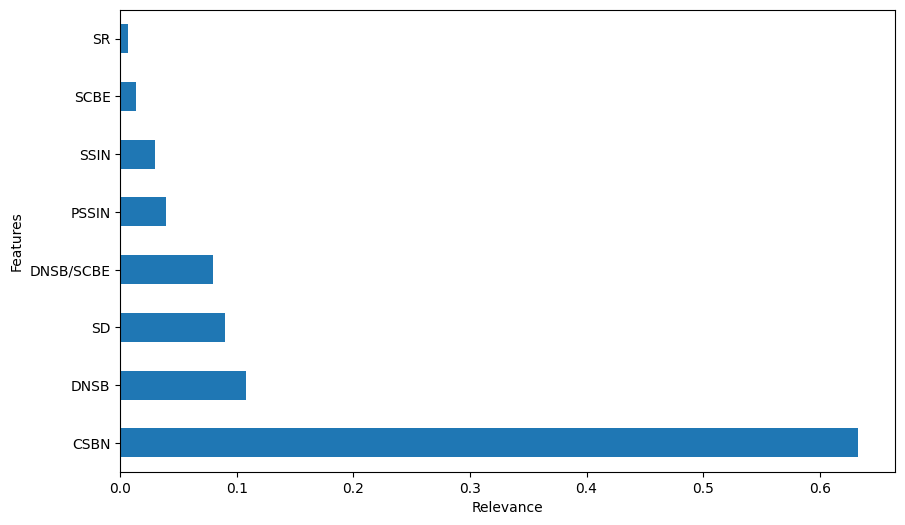

(0.022764637843406575,
 CSBN         0.633216
 DNSB         0.107485
 SD           0.090179
 DNSB/SCBE    0.079850
 PSSIN        0.039320
 SSIN         0.029701
 SCBE         0.013401
 SR           0.006848
 dtype: float64)

In [218]:
# Definimos las variables predictoras y la variable objetivo

df_departamento=df[df['DEPARTAMENTO']=='SANTANDER']
X = df_departamento[['SCBE', 'SD', 'SR', 'SSIN', 'PSSIN','DNSB', 'CSBN', 'DNSB/SCBE']]
y = df_departamento['TDA']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo de Random Forest
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Realizamos predicciones y evaluamos el modelo
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Importancia de las características
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Visualizamos la importancia de las características
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='barh')
#plt.title('Importancia de las Características')
plt.xlabel('Relevance')
plt.ylabel('Features')
plt.show()
rmse, feature_importances

## 13. Modelos de predicción - Regresión (Departamento Atántico)

**División de Datos**

Divide tu conjunto de datos en datos de entrenamiento y datos de prueba

In [219]:
#### Variables predictoras y la variable objetivo
df_departamento=df[df['DEPARTAMENTO']=='ATLÁNTICO']
X = df_departamento[['DNSB', 'DNSB/SCBE', 'CSBN', 'SD']]
y = df_departamento['TDA']

# División conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


#### Entrena cada uno de los modelos en los datos de entrenamiento.

# Inicialización de modelos
modelos = {
    'Regresión Lineal': LinearRegression(),
    'Árbol de Decisión': DecisionTreeRegressor(),
    'SVM': SVR(),
    'Regresor Random Forest': RandomForestRegressor()
}

# Entrenamiento
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)

#### Evaluación con Métricas**

#Evalúa el rendimiento de cada modelo utilizando métricas adecuadas para problemas de regresión.
#Algunas métricas comunes incluyen

resultados = {}

for nombre, modelo in modelos.items():
    # Predicciones en datos de prueba
    y_pred = modelo.predict(X_test)

    # Calcula métricas
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    resultados[nombre] = {'MSE': mse, 'MAE': mae, 'R²': r2}

# Mostrar resultados
for nombre, result in resultados.items():
    print(f"Modelo: {nombre}")
    print(f"  MSE: {result['MSE']:.2f}")
    print(f"  MAE: {result['MAE']:.2f}")
    print(f"  R²: {result['R²']:.2f}")
    print()

Modelo: Regresión Lineal
  MSE: 0.00
  MAE: 0.00
  R²: 1.00

Modelo: Árbol de Decisión
  MSE: 0.01
  MAE: 0.07
  R²: 0.98

Modelo: SVM
  MSE: 0.05
  MAE: 0.21
  R²: 0.88

Modelo: Regresor Random Forest
  MSE: 0.01
  MAE: 0.07
  R²: 0.99



## 13. Modelos de predicción - Regresión (Departamento Sucre)

In [220]:
### Variables predictoras y la variable objetivo
df_departamento=df[df['DEPARTAMENTO']=='SUCRE']
X = df_departamento[['DNSB', 'DNSB/SCBE', 'CSBN', 'SD']]
y = df_departamento['TDA']

# División conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


#### Entrena cada uno de los modelos en los datos de entrenamiento.

# Inicialización de modelos
modelos = {
    'Regresión Lineal': LinearRegression(),
    'Árbol de Decisión': DecisionTreeRegressor(),
    'SVM': SVR(),
    'Regresor Random Forest': RandomForestRegressor()
}

# Entrenamiento
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)

#### Evaluación con Métricas**

#Evalúa el rendimiento de cada modelo utilizando métricas adecuadas para problemas de regresión.
#Algunas métricas comunes incluyen

resultados = {}

for nombre, modelo in modelos.items():
    # Predicciones en datos de prueba
    y_pred = modelo.predict(X_test)

    # Calcula métricas
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    resultados[nombre] = {'MSE': mse, 'MAE': mae, 'R²': r2}

# Mostrar resultados
for nombre, result in resultados.items():
    print(f"Modelo: {nombre}")
    print(f"  MSE: {result['MSE']:.2f}")
    print(f"  MAE: {result['MAE']:.2f}")
    print(f"  R²: {result['R²']:.2f}")
    print()

Modelo: Regresión Lineal
  MSE: 0.00
  MAE: 0.00
  R²: 1.00

Modelo: Árbol de Decisión
  MSE: 0.01
  MAE: 0.07
  R²: 0.91

Modelo: SVM
  MSE: 0.05
  MAE: 0.17
  R²: 0.62

Modelo: Regresor Random Forest
  MSE: 0.01
  MAE: 0.05
  R²: 0.95



## 13. Modelos de predicción - Regresión (Departamento Meta)

In [221]:
### Variables predictoras y la variable objetivo
df_departamento=df[df['DEPARTAMENTO']=='META']
X = df_departamento[['DNSB', 'DNSB/SCBE', 'CSBN', 'SD']]
y = df_departamento['TDA']

# División conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


#### Entrena cada uno de los modelos en los datos de entrenamiento.

# Inicialización de modelos
modelos = {
    'Regresión Lineal': LinearRegression(),
    'Árbol de Decisión': DecisionTreeRegressor(),
    'SVM': SVR(),
    'Regresor Random Forest': RandomForestRegressor()
}

# Entrenamiento
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)

#### Evaluación con Métricas**

#Evalúa el rendimiento de cada modelo utilizando métricas adecuadas para problemas de regresión.
#Algunas métricas comunes incluyen

resultados = {}

for nombre, modelo in modelos.items():
    # Predicciones en datos de prueba
    y_pred = modelo.predict(X_test)

    # Calcula métricas
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    resultados[nombre] = {'MSE': mse, 'MAE': mae, 'R²': r2}

# Mostrar resultados
for nombre, result in resultados.items():
    print(f"Modelo: {nombre}")
    print(f"  MSE: {result['MSE']:.2f}")
    print(f"  MAE: {result['MAE']:.2f}")
    print(f"  R²: {result['R²']:.2f}")
    print()

Modelo: Regresión Lineal
  MSE: 0.00
  MAE: 0.00
  R²: 1.00

Modelo: Árbol de Decisión
  MSE: 0.02
  MAE: 0.10
  R²: 0.90

Modelo: SVM
  MSE: 0.00
  MAE: 0.05
  R²: 0.98

Modelo: Regresor Random Forest
  MSE: 0.01
  MAE: 0.06
  R²: 0.96



## 13. Modelos de predicción - Regresión (Departamento Santander)

In [222]:
### Variables predictoras y la variable objetivo
df_departamento=df[df['DEPARTAMENTO']=='SANTANDER']
X = df_departamento[['DNSB', 'DNSB/SCBE', 'CSBN', 'SD']]
y = df_departamento['TDA']

# División conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


#### Entrena cada uno de los modelos en los datos de entrenamiento.

# Inicialización de modelos
modelos = {
    'Regresión Lineal': LinearRegression(),
    'Árbol de Decisión': DecisionTreeRegressor(),
    'SVM': SVR(),
    'Regresor Random Forest': RandomForestRegressor()
}

# Entrenamiento
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)

#### Evaluación con Métricas**

#Evalúa el rendimiento de cada modelo utilizando métricas adecuadas para problemas de regresión.
#Algunas métricas comunes incluyen

resultados = {}

for nombre, modelo in modelos.items():
    # Predicciones en datos de prueba
    y_pred = modelo.predict(X_test)

    # Calcula métricas
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    resultados[nombre] = {'MSE': mse, 'MAE': mae, 'R²': r2}

# Mostrar resultados
for nombre, result in resultados.items():
    print(f"Modelo: {nombre}")
    print(f"  MSE: {result['MSE']:.2f}")
    print(f"  MAE: {result['MAE']:.2f}")
    print(f"  R²: {result['R²']:.2f}")
    print()

Modelo: Regresión Lineal
  MSE: 0.00
  MAE: 0.00
  R²: 1.00

Modelo: Árbol de Decisión
  MSE: 0.00
  MAE: 0.02
  R²: 0.93

Modelo: SVM
  MSE: 0.01
  MAE: 0.08
  R²: 0.61

Modelo: Regresor Random Forest
  MSE: 0.00
  MAE: 0.03
  R²: 0.93

